#### Pertama, kita impor library penting untuk preprocessing teks dan pembagian data
#### Library berikut digunakan untuk:

#### Tokenisasi teks (mengubah kata menjadi angka)

#### Padding (menyamakan panjang input)

#### Split dataset ke data latih dan data uji

In [1]:
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Load CSV
df = pd.read_csv("/kaggle/input/steam-reviews/output.csv")

# Ambil kolom penting
df = df[['content', 'is_positive']]

# Buang baris kosong/null
df = df.dropna()

# Ubah label ke format numerik
df['label'] = df['is_positive'].map({'Positive': 1, 'Negative': 0})

# Lihat distribusi label
print(df['label'].value_counts())

# Simpan bersih ke CSV baru (optional)
df[['content', 'label']].to_csv("steam_reviews_clean.csv", index=False)


label
1    102377
0     98346
Name: count, dtype: int64


#### Kemudian kita baca file CSV yang berisi data ulasan dari Steam
#### File ini berisi dua kolom penting:
#### content: teks ulasan
#### label: 1 untuk positif, 0 untuk negatif
#### Kita tetapkan parameter untuk tokenisasi dan padding
#### max_words: jumlah maksimum kata unik yang digunakan (10.000 kata)
#### max_len: panjang maksimal teks (100 token per ulasan)
#### Kita ubah teks ke urutan angka dan lakukan padding texts_to_sequences: mengubah setiap review menjadi daftar angka , pad_sequences: memastikan semua input punya panjang yang sama (100 token)
#### Ambil label dari dataset
#### Label ini berupa 0 (negatif) dan 1 (positif), yang akan digunakan untuk training dan evaluasi model.

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress log TensorFlow


# Load data bersih
df = pd.read_csv("steam_reviews_clean.csv")

# Parameter
max_words = 10000  # jumlah kata unik maksimum
max_len = 100      # panjang teks maksimal

# Tokenisasi
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content'])

# Ubah ke urutan angka
sequences = tokenizer.texts_to_sequences(df['content'])

# Padding
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Label
labels = df['label'].values

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

print("Data siap untuk modeling!")


Data siap untuk modeling!


#### sebelum membangun model, kita paksa TensorFlow menggunakan CPU saja
#### Ini dilakukan supaya menghindari error CUDA, khususnya kalau kamu nggak punya GPU atau ingin jalan di perangkat biasa.
#### Kita bangun model klasifikasi teks menggunakan arsitektur LSTM Struktur model: -Embedding Layer: mengubah kata jadi vektor, -LSTM: menangkap urutan kata dan konteks, -Dropout: mengurangi overfitting ,  -Dense: output 1 neuron, sigmoid untuk klasifikasi biner

#### Kita kompilasi model sebelum pelatihan
#### Loss function: binary_crossentropy karena ini klasifikasi dua kelas.
#### Optimizer: adam karena cepat dan adaptif.
#### Metrik evaluasi: accuracy.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Jalankan pelatihan model menggunakan data latih
#### Model akan belajar selama 10 epoch.
#### Sebagian dari data latih (20%) dipakai untuk validasi selama training.

In [4]:
# Latih model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)


Epoch 1/10
4015/4015 - 163s - 40ms/step - accuracy: 0.5392 - loss: 0.6845 - val_accuracy: 0.6344 - val_loss: 0.6380
Epoch 2/10
4015/4015 - 156s - 39ms/step - accuracy: 0.7390 - loss: 0.5351 - val_accuracy: 0.8215 - val_loss: 0.4226
Epoch 3/10
4015/4015 - 155s - 39ms/step - accuracy: 0.8323 - loss: 0.3892 - val_accuracy: 0.8386 - val_loss: 0.3537
Epoch 4/10
4015/4015 - 154s - 38ms/step - accuracy: 0.8595 - loss: 0.3278 - val_accuracy: 0.8574 - val_loss: 0.3224
Epoch 5/10
4015/4015 - 154s - 38ms/step - accuracy: 0.8738 - loss: 0.2951 - val_accuracy: 0.8584 - val_loss: 0.3256
Epoch 6/10
4015/4015 - 154s - 38ms/step - accuracy: 0.8846 - loss: 0.2707 - val_accuracy: 0.8601 - val_loss: 0.3257
Epoch 7/10
4015/4015 - 154s - 38ms/step - accuracy: 0.8944 - loss: 0.2486 - val_accuracy: 0.8574 - val_loss: 0.3541
Epoch 8/10
4015/4015 - 154s - 38ms/step - accuracy: 0.9034 - loss: 0.2294 - val_accuracy: 0.8574 - val_loss: 0.3513
Epoch 9/10
4015/4015 - 155s - 38ms/step - accuracy: 0.9110 - loss: 0.212

#### Setelah training, kita evaluasi performa model di data uji
#### Fungsi evaluate akan menampilkan loss dan akurasi terhadap data test (yang belum pernah dilihat model).

In [5]:
# Evaluasi di data test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2%}")


1255/1255 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8566 - loss: 0.3894
Test Accuracy: 85.48%


#### Kita buat confusion matrix dan classification report
#### Confusion matrix sangat membantu untuk melihat:

#### Berapa banyak prediksi positif/negatif yang benar atau salah

#### Seberapa baik model membedakan dua kelas

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


1255/1255 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
[[16172  3484]
 [ 2346 18143]]
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     19656
           1       0.84      0.89      0.86     20489

    accuracy                           0.85     40145
   macro avg       0.86      0.85      0.85     40145
weighted avg       0.86      0.85      0.85     40145



#### Terakhir, kita visualisasikan grafik akurasi pelatihan vs validasi
#### Ini membantu melihat apakah model mengalami overfitting atau tidak.

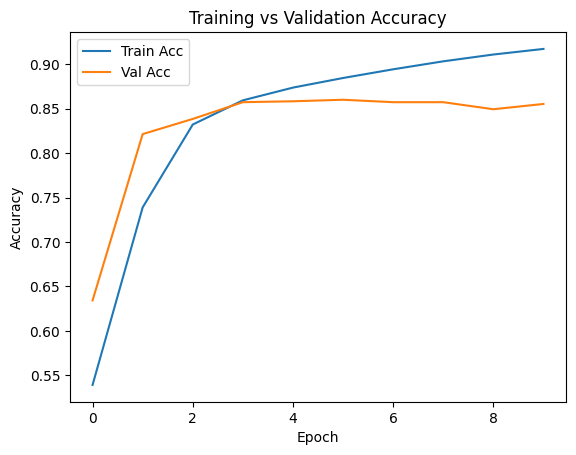

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()
